In [35]:

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras import Sequential, layers, utils
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import VGG16

In [36]:
img_width = 224
img_height = 224
batch_size = 32
epochs = 25

data = []
targets = []
filenames = []

BASE_PATH = "C:\\Abhishek_Data\\My_Data\\Datasets\\Detection\\od_notebooks\\dataset\\"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "airplanes.csv"])

rows = open(ANNOTS_PATH).read().strip().split("\n")

# loop over the rows
for row in rows:
    # break the row into the filename and bounding box coordinates
    (filename, startX, startY, endX, endY) = row.split(",")

    # derive the path to the input image, load the image (in OpenCV
    # format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]

    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    # load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)

    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

debug = 999

In [37]:
model = Sequential()
model.add(VGG16(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3)))

for layer in model.layers:
    layer.trainable = False

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(4, activation="sigmoid"))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_21 (Dense)            (None, 128)               3211392   
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 4)                 132       
                                                                 
Total params: 17936548 (68.42 MB)
Trainable params: 3

In [38]:
# model training (adding and retraining top classification layers not fine tuning)
import datetime, os

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

history = model.fit(
  trainImages, trainTargets, 
  validation_data=(testImages, testTargets),
  epochs=epochs,
  batch_size=batch_size,
  callbacks=[tensorboard_callback]
)

Epoch 1/25
23/23 [==============================] - 101s 4s/step - loss: 0.0236 - val_loss: 0.0016
Epoch 2/25
23/23 [==============================] - 104s 5s/step - loss: 0.0015 - val_loss: 7.5403e-04
Epoch 3/25
23/23 [==============================] - 104s 5s/step - loss: 9.3515e-04 - val_loss: 6.0820e-04
Epoch 4/25
23/23 [==============================] - 101s 4s/step - loss: 7.2890e-04 - val_loss: 5.2897e-04
Epoch 5/25
23/23 [==============================] - 96s 4s/step - loss: 6.0996e-04 - val_loss: 5.1781e-04
Epoch 6/25
23/23 [==============================] - 95s 4s/step - loss: 4.9731e-04 - val_loss: 5.2311e-04
Epoch 7/25
23/23 [==============================] - 96s 4s/step - loss: 4.3105e-04 - val_loss: 4.9305e-04
Epoch 8/25
23/23 [==============================] - 96s 4s/step - loss: 3.5664e-04 - val_loss: 5.0246e-04
Epoch 9/25
23/23 [==============================] - 96s 4s/step - loss: 3.1931e-04 - val_loss: 4.9529e-04
Epoch 10/25
23/23 [==============================] - 9

In [39]:
model.save("01_localization.h5", save_format="h5")

c:\Users\abhishek.sri\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


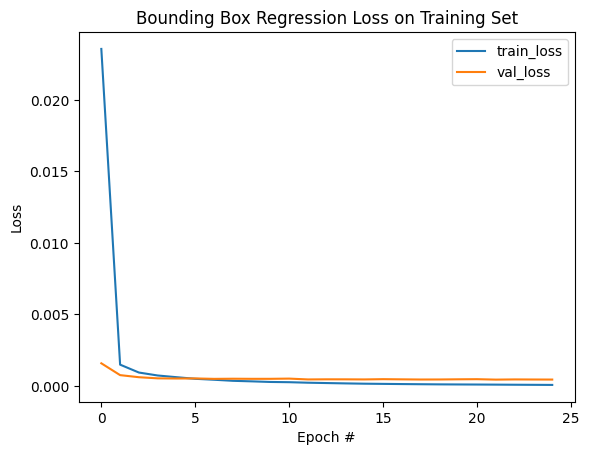

In [40]:
N = history.params['epochs']
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

In [41]:
from keras.models import load_model
model = load_model('01_localization.h5')

In [42]:
def inference(imagePath):
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # make bounding box predictions on the input image
    preds = model.predict(image)[0]
    return preds

In [43]:
def draw_bbox(img, preds):
    image = np.copy(img)
    (startX, startY, endX, endY) = preds
    (h, w) = image.shape[:2]

    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # draw the predicted bounding box on the image
    cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
    return image

1/1 [==============================] - 0s 138ms/step


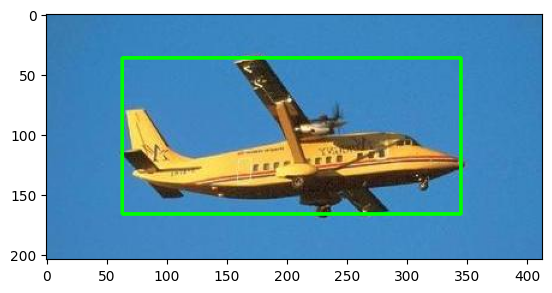

In [62]:
imagePath = 'C:\\Abhishek_Data\\My_Data\\Datasets\\Detection\\od_notebooks\\dataset\\images\\image_0569.jpg'
image = plt.imread(imagePath)
preds = inference(imagePath)
image_with_bbox = draw_bbox(image, preds)

# show the output image
plt.imshow(image_with_bbox)